In [47]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits
import tempfile
temp_dir = tempfile.TemporaryDirectory()
from casatasks import simobserve, tclean, exportfits
import os
import shutil
from casatools import table
from astropy.constants import c
import astropy.units as U
os.environ['MPLCONFIGDIR'] = temp_dir.name

In [92]:
def load_fits(inFile):
    hdu_list = fits.open(inFile)
    data = hdu_list[0].data
    header = hdu_list[0].header
    hdu_list.close()
    return data, header

def get_band_central_freq(band):
    if band == 3:
        return '100GHz'
    elif band == 6:
        return '250GHz'
    elif band == 8:
        return '545GHz'
    elif band == 9:
        return '650GHz'

def my_asserteq(*args):
    for aa in args[1:]:
        if args[0] != aa:
            raise RuntimeError(f"{args[0]} != {aa}")

def _ms2resolve_transpose(arr):
    my_asserteq(arr.ndim, 3)
    return np.ascontiguousarray(np.transpose(arr, (0, 2,1)))


def ms_to_npz(ms, dirty_cube, datacolumn='CORRECTED_DATA', output_file='test.npz'):
    tb = table()
    tb.open(ms)
    
    #get frequency info from dirty cube
    with fits.open(dirty_cube, memmap=False) as hdulist: 
            npol, nz,nx, ny = np.shape(hdulist[0].data)
            header=hdulist[0].header
    crdelt3 = header['CDELT3']
    crval3 = header['CRVAL3']
    wave = ((crdelt3 * (np.arange(0, nz, 1))) + crval3) #there will be problems, channels       are not of the same width in real data

    vis = tb.getcol(datacolumn)
    vis = np.ascontiguousarray(_ms2resolve_transpose(vis))

    wgt = tb.getcol('WEIGHT')
    wgt = np.repeat(wgt[:,None],128,axis=1)
    #this is to get vis and wgt on the same shape if ms has column weighted_spectrum this       should be different
    wgt = np.ascontiguousarray(_ms2resolve_transpose(wgt))

    uvw = np.transpose(tb.getcol('UVW'))

    np.savez_compressed(output_file,
                    freq = wave,
                    vis= vis, 
                    weight= wgt,
                    polarization=[9,12], 
                    antpos0=uvw,
                    antpos1=tb.getcol('ANTENNA1'),
                    antpos2=tb.getcol('ANTENNA2'),
                    antpos3=tb.getcol('TIME'))

def get_fov(bands):
    light_speed = c.to(U.m / U.s).value
    fovs = []
    for band in bands:
        if band == 1:
            central_freq = 43 * U.GHz  
        elif band == 3:
            central_freq = 100 * U.GHz
        elif band == 4:
            central_freq = 143 * U.GHz
        elif band == 5:
            central_freq = 217 * U.GHz
        elif band == 6:
            central_freq = 250 * U.GHz
        elif band == 7:
            central_freq = 353 * U.GHz
        elif band == 8:
            central_freq = 545 * U.GHz
        elif band == 9:
            central_freq = 650 * U.GHz    
        elif band == 10:
            central_freq = 850 * U.GHz
           
        central_freq = central_freq.to(U.Hz).value
        central_freq_s = 1 / central_freq
        amplitude = light_speed * central_freq_s
        fov = 1.2 * amplitude / 12
        fov = fov * 180 / np.pi * 3600
        fovs.append(fov)
    return np.array(fovs)

n_px 670
pixel_size 0.04428571428571428  arcsec
fov 24.73465330548431  arcsec
spatial_resolution 0.31  arcsec


2023-03-27 15:20:25	WARN	simobserve::::	FITS card 25: CRPIX3  = '0       '                                                            
2023-03-27 15:20:25	WARN	simobserve::::	Keyword value has wrong data type.
2023-03-27 15:20:25	WARN	simobserve::::	FITS card 25: CRPIX3  = '0       '                                                            
2023-03-27 15:20:25	WARN	simobserve::::	Keyword value has wrong data type.
CRPIX3  = '0       '                                                            
  Rejected (1), a floating-point value was expected.
2023-03-27 15:20:28	WARN	noise::CTPatchedInterp::interpolate	In caltable sim_1.alma.cycle9.3.3.noisy.T.cal_sim_temp (Tf Jones):
2023-03-27 15:20:28	WARN	noise::CTPatchedInterp::interpolate+	 Insufficient solution channel sampling (nchan=1) for frequency-dependent LINEAR interpolation 
2023-03-27 15:20:28	WARN	noise::CTPatchedInterp::interpolate+	 of calibration for MS spw=0; using NEAREST instead.
2023-03-27 15:20:29	WARN	SynthesisParamsImage

SIMPLE  =                    T /Standard FITS                                   BITPIX  =                  -32 /Floating point (32 bit)                         NAXIS   =                    4                                                  NAXIS1  =                  300                                                  NAXIS2  =                  300                                                  NAXIS3  =                    1                                                  NAXIS4  =                    1                                                  EXTEND  =                    T                                                  BSCALE  =   1.000000000000E+00 /PHYSICAL = PIXEL*BSCALE + BZERO                 BZERO   =   0.000000000000E+00                                                  BTYPE   = 'Intensity'                                                           OBJECT  = '        '                                                            BUNIT   = 'Jy/pixel'           /Brightne

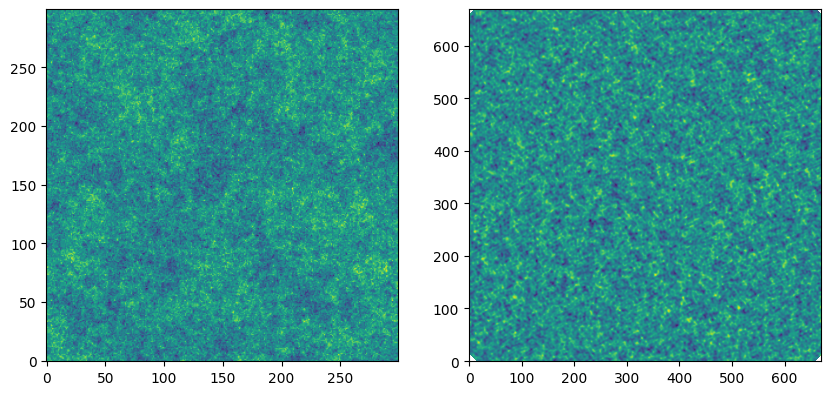

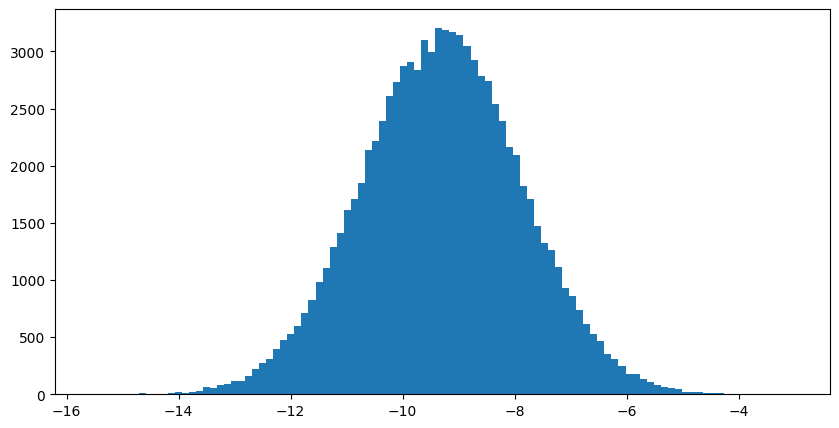

In [94]:
i = 1
datadir = '/mnt/d/Astro/'
output_dir = 'sims'
output_dir = os.path.join(datadir, output_dir)
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
project = 'sim_{}'.format(i)
name = 'sky_{}.fits'.format(i)
filename = os.path.join(datadir, name)
band = 6
spatial_resolution = 0.31
central_freq = get_band_central_freq(band)
fov = get_fov([band])[0]
pixel_size = spatial_resolution / 7
n_px = int(1.2 * fov / pixel_size)

print('n_px', n_px)
print('pixel_size', pixel_size, ' arcsec')
print('fov', fov, ' arcsec')
print('spatial_resolution', spatial_resolution, ' arcsec')

antenna_name = 'alma.cycle9.3.3'
antennalist = os.path.join('/home/michele/GitHub/ALMASim/antenna_config', antenna_name + '.cfg')

simobserve(
        project=project, 
        skymodel=filename,
        inbright="0.001Jy/pix",
        incell="{}arcsec".format(pixel_size),
        indirection="J2000 19h30m00 -40d00m00",
        incenter=central_freq,
        inwidth="10MHz",
        setpointings=True,
        integration="10s",
        mapsize=["{}arcsec".format(fov)],
        maptype="square",
        obsmode="int",
        antennalist=antennalist,
        totaltime="2400s",
        thermalnoise="tsys-atm",
        user_pwv=0.3,
        seed=11111,
        graphics="none",
        verbose=False,
        overwrite=True)
tclean(
        vis=os.path.join(project, "{}.{}.noisy.ms".format(project, antenna_name)),
        imagename=os.path.join(project, '{}.{}'.format(project, antenna_name)),
        imsize=[int(n_px), int(n_px)],
        cell="{}arcsec".format(pixel_size),
        phasecenter="J2000 19h30m00 -40d00m00",
        specmode="cube",
        niter=0,
        fastnoise=False,
        calcpsf=True,
        pbcor=False
        )
exportfits(imagename=os.path.join(project, '{}.{}.image'.format(project, antenna_name)), 
           fitsimage=os.path.join(output_dir, "dirty_cube_" + str(i) +".fits"), overwrite=True)
exportfits(imagename=os.path.join(project, '{}.{}.skymodel'.format(project, antenna_name)), 
           fitsimage=os.path.join(output_dir, "clean_cube_" + str(i) +".fits"), overwrite=True)

ms_to_npz(os.path.join(project, "{}.{}.noisy.ms".format(project, antenna_name)),
              dirty_cube=os.path.join(output_dir, "dirty_cube_" + str(i) +".fits"),
              datacolumn='CORRECTED_DATA',
              output_file=os.path.join(output_dir, "{}.{}.noisy_".format(project, antenna_name) + str(i) +".npz"))
shutil.rmtree(project)

clean_data, clean_header = load_fits(os.path.join(output_dir, "clean_cube_" + str(i) +".fits"))
dirty_data, dirty_header = load_fits(os.path.join(output_dir, "dirty_cube_" + str(i) +".fits"))

print(clean_header)


print(np.max(clean_data))
print(np.min(clean_data))
print(np.mean(clean_data))
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(np.log10(clean_data[0, 0, :, :]), origin='lower')
ax[1].imshow(dirty_data[0, 0, :, :], origin='lower')
plt.show()

plt.figure(figsize=(10, 5))
plt.hist(np.log10(clean_data.flatten()), bins=100)
plt.show()